In [27]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [28]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device =  torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 3060


### Read a batch of training images along with their bounding boxes and lables.
In this example, I use read only 1 image, i.e., batch_size=1

(1333, 2000, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

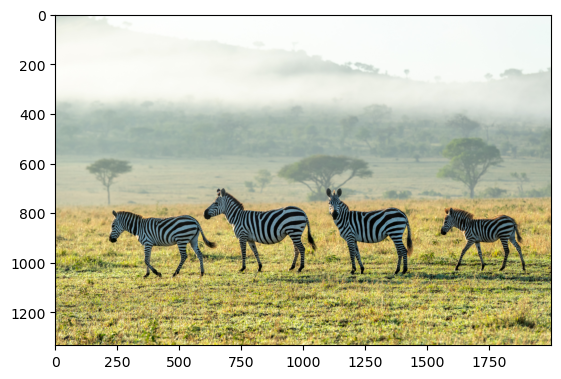

In [29]:
# input image could be of any size
img0 = cv2.imread('zebras.jpg')
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show

In [30]:
# Object information: a set of bounding boxes [ymin, xmin, ymax, xmax] and their labels
bbox0 = np.array([[782, 223, 1074, 623], [695, 597, 1050, 1038],
                 [699, 1088, 1057, 1452], [771, 1544, 1063, 1914]])

labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

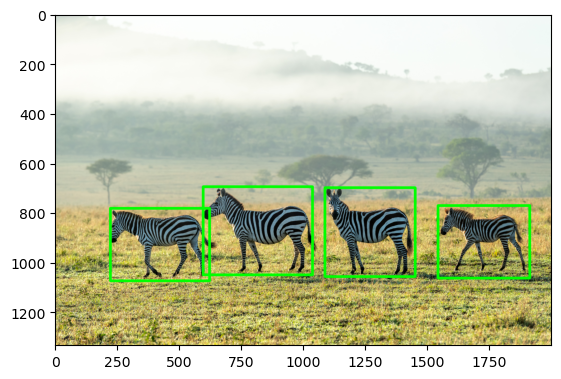

In [31]:
# display bounding box and labels
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]),
                              (bbox0[i][3], bbox0[i][2]),
                        color = (0, 255, 0), thickness=10)
    
plt.imshow(img0_clone)
plt.show()

### Resize the input images to (h=800, w=800)


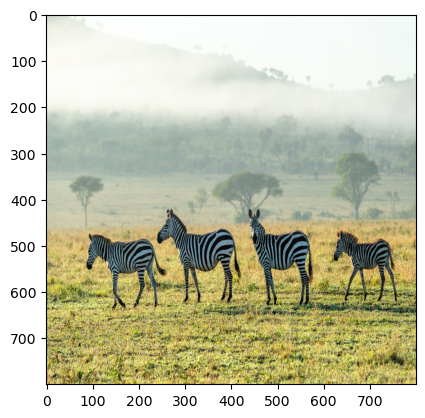

In [32]:
img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [33]:
# change the bounding box coordinates
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioLst)]
    bbox.append(box)

bbox = np.array(bbox)
print(bbox)

[[469  89 644 249]
 [417 238 630 415]
 [419 435 634 580]
 [462 617 637 765]]


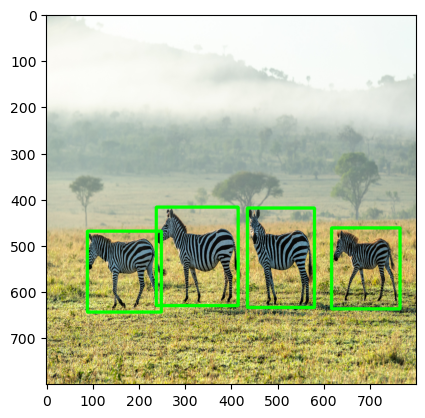

In [34]:

# display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=5)

plt.imshow(img_clone)
plt.show()


### Use VGG16 to extract features from input images

#### Input images (batch_size, H=800, W=800, d=3), Features: (batch_size, H=50, W=50, d=512)

In [35]:
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(len(fe))

31


In [36]:
# collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800]
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    print(i)
    k = i(k)
    if k.size()[2] < 800 // 16:     # 800//16 = 50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) #512

torch.Size([1, 3, 800, 800])
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padd

In [37]:
# Convert this list into a Sequential module
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [38]:
# get feature by passing vgg using input image
transform = transforms.Compose([transforms.ToTensor()]) #Defing Pytorch Transform
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


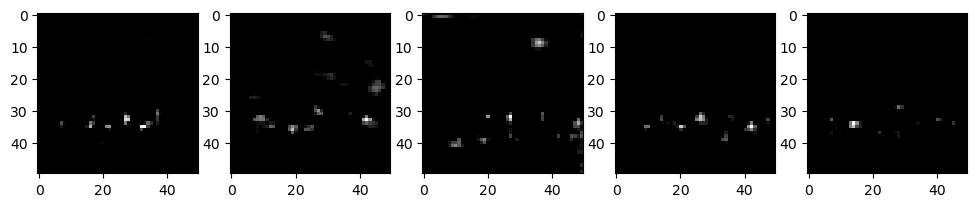

In [42]:
# visualize the first 5 channels of the 50 * 50 * 512 feature maps
imgArray = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1

plt.show()

### Generate 22,500 anchor boxes on each input image

50 x 50 = 2500 anchors, each other generate 9 anchors, Total = 50 x 50 x 9 = 22,500

In [43]:
# x, y intervals to generate anchor box center
fe_size = (800 // 16)
ctr_x = np.arange(16, (fe_size + 1) * 16, 16)
ctr_y = np.arange(16, (fe_size + 1) * 16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [46]:
# coordinates of the 2500 center points to generate anchor boxes
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index += 1

print(ctr.shape)

(2500, 2)


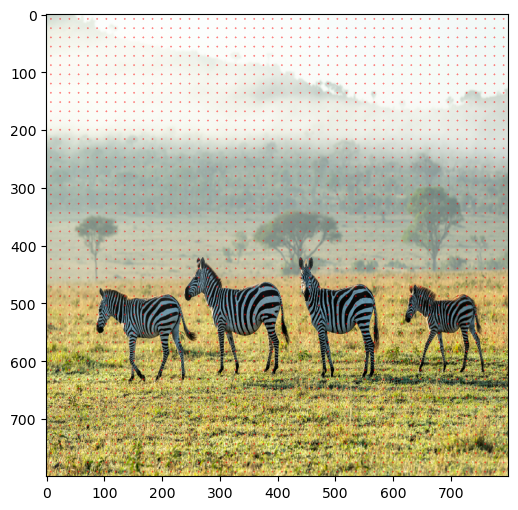

In [48]:
# display the 2500 anchors 
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))

for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1)

plt.imshow(img_clone)
plt.show()

In [49]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500 * 9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros(((fe_size * fe_size * 9), 4))
index = 0

for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1. / ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)
            

(22500, 4)


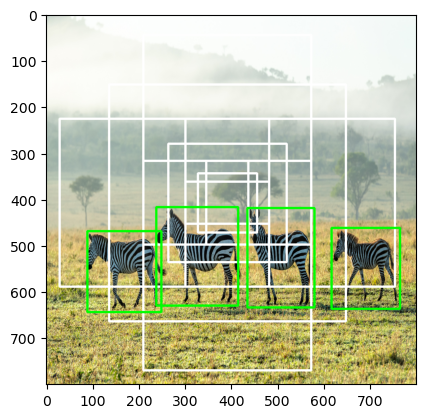

In [50]:
# display the 9 anchor boxes of one anchor and the ground truth bbox
img_clone = np.copy(img)
for i in range(11025, 11034): #9 * 1225 = 11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 2550), thickness=3)
    
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle
    
plt.imshow(img_clone)
plt.show()

In [55]:
# Ignore cross-boundary anchor boxes
# valid anchor boxes with (y1, x1) > 0 and (y2, x2) <= 800
index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) & 
    (anchor_boxes[:, 1] >= 0) &
    (anchor_boxes[:, 2] <= 800) &
    (anchor_boxes[:, 3] <= 800)
)[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


In [62]:
# Calculate iou of the valid anchor boxes
# Since we have 8940 anchor boxes and 4 ground truth objects, we should get an array with (8490, 4) as the output.
ious = np.empty((len(valid_anchor_boxes), 4), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 -xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)
        else:
            iou = 0.
        ious[num1, num2] = iou

print(ious.shape)

(8940, 4)


In [63]:
# What anchor box has max iou with the ground truth bbox
gt_argmax_ious = ious.argmax(axis=0)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[0.58514285 0.5752716  0.5255493  0.6325869 ]
[1008 1013 1018 1226 1232 1238 2862 2869 2876 3108 3115 3122 3336 3343
 3350 3354 3357 3361 3364 3368 3371 3377 3383 3389 3600 3607 3614 3846
 3853 3860 5935 5942 6164 6171 6178 6181 6185 6188 6192 6198 6427 6434
 8699 8703 8707]


In [64]:
# What ground truth bbox is assciated with each anchor box
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 3 3 3]
[0.         0.         0.         ... 0.11051063 0.08043041 0.05193678]


In [66]:
# set the labels of 8940 valid anchor boxes to -1(ignore)

label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [67]:

# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3

pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [68]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=len(neg_index) - n_neg, replace=False)
    label[disable_index] = -1

In [73]:
# convert the format of valid anchor boxes [y1, x1, y2, x2]

# For each valid anchor box, find the groundtruth object which has max_iou
max_iou_bbox = bbox[argmax_ious]
print(bbox)
print(argmax_ious.shape)
print(max_iou_bbox)
print(max_iou_bbox.shape)

# valid anchor boxes, h, w, cx, cy
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)



[[469  89 644 249]
 [417 238 630 415]
 [419 435 634 580]
 [462 617 637 765]]
(8940,)
[[469  89 644 249]
 [469  89 644 249]
 [469  89 644 249]
 ...
 [462 617 637 765]
 [462 617 637 765]
 [462 617 637 765]]
(8940, 4)
(8940, 4)


In [75]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)


(22500,)
(22500, 4)


### RPN(Reigion Proposal Network)

In [ ]:
in_channels = 512  # depends on the output feature map, in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9    # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(device)
